In [1]:
%matplotlib inline
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warnings and info
import tensorflow as tf
import tensorflow.keras as keras
import imageio
import moviepy.editor as mpy

SAMPLE_COL = 8
SAMPLE_ROW = 8
SAMPLE_NUM = SAMPLE_COL * SAMPLE_ROW

dataset_size = 202599
from pathlib import Path
IMG_H = 64
IMG_W = 64
IMG_C = 3
IMG_SHAPE = (IMG_H, IMG_W, IMG_C)
IMG_DIR = '/home/jinghao/miniconda3/2021_Deep_Learning/DL_lab14_GAN/dataset'

BATCH_SIZE = 500
Z_DIM = 128
BZ = (BATCH_SIZE, Z_DIM)
BUF = 65536

W_LR = 2.0e-04
SW_LR = 1.0e-04
SW_beta1 = 0
SW_beta2 = 0.9
W_EPOCH = 50

In [2]:
def preprocess(image_name):
    image_file = tf.io.read_file('/home/jinghao/miniconda3/2021_Deep_Learning/DL_lab14_GAN/dataset/'+image_name)
    image = tf.io.decode_png(image_file, channels=3)
    image = tf.image.resize(image, size=[IMG_H, IMG_W])
    image = tf.divide(tf.cast(image, tf.float32), 255.0)
    
    return image

img_name_list = []
paths = Path(IMG_DIR).glob('*.png')

for i, path in enumerate(paths):
    name = str(path.resolve()).strip().split('/')[-1]
    img_name_list.append(name)

dataset_train = tf.data.Dataset.from_tensor_slices(img_name_list)
dataset_train = dataset_train.shuffle(BUF)
dataset_train = dataset_train.map(preprocess, num_parallel_calls = tf.data.experimental.AUTOTUNE)
dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder=True)
dataset_train = dataset_train.prefetch(buffer_size=128)

In [3]:
# Utility function
def utPuzzle(imgs, row, col, path=None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h : (j + 1) * h, i * w : (i + 1) * w, :] = img
    if path is not None : imageio.imwrite(path, out)
    return out
  
def utMakeGif(imgs, fname, duration):
    n = float(len(imgs)) / duration
    clip = mpy.VideoClip(lambda t : imgs[int(n * t)], duration = duration)
    clip.write_gif(fname, fps = n)

In [4]:
def GAN(img_shape, z_dim):
    # x-shape
    xh, xw, xc = img_shape
    # z-shape
    zh = xh // 4
    zw = xw // 4
        
    # return Generator and Discriminator
    return keras.Sequential([ # Generator
        keras.layers.Dense(units  =  1024, input_shape = (z_dim,)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(units  =  zh * zw << 8), # zh * zw * 256
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Reshape(target_shape = (zh, zw, 256)),
        keras.layers.Conv2DTranspose(
            filters = 32,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Conv2DTranspose(
            filters = xc,
            kernel_size = 5,
            strides = 2,
            padding = "SAME",
            activation = keras.activations.sigmoid
        ),
    ]), keras.Sequential([ # Discriminator
        keras.layers.Conv2D(
            filters = 32,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME",
            input_shape = img_shape,
        ),
        keras.layers.LeakyReLU(),
        keras.layers.Conv2D(
            filters = 128,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Flatten(),
        keras.layers.Dense(units  =  1024),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(units  =  1),
    ])

In [18]:
WG, WD = GAN(IMG_SHAPE, Z_DIM)
optimizer_g = keras.optimizers.RMSprop(W_LR)
optimizer_d = keras.optimizers.RMSprop(W_LR)


@tf.function
def WGTrain(c1):
    z = tf.random.normal(BZ)
    epsilon = tf.random.uniform(shape=[])
    with tf.GradientTape() as tpg:
        c0 = WG(z, training=True)

        z1 = WD(c1, training=True)
        z0 = WD(c0, training=True)

        c_hat = epsilon*c1 + (1-epsilon)*c0
        with tf.GradientTape() as R:
            R.watch(c_hat)
            zp = WD(c_hat, training=True)

        gradient = R.gradient(zp, c_hat)
        penalty = 10.0*tf.square((tf.nn.l2_loss(gradient)-1.0))
        ld = tf.reduce_mean(z0)
        lg = - ld
        ld = ld - tf.reduce_mean(z1) + penalty

    gradient_g = tpg.gradient(lg, WG.trainable_variables)

    optimizer_g.apply_gradients(zip(gradient_g, WG.trainable_variables))

    return lg, ld


@tf.function
def WDTrain(c1):
    z = tf.random.normal(BZ)
    epsilon = tf.random.uniform(shape=[])
    with tf.GradientTape() as tpd:
        c0 = WG(z, training=True)

        z1 = WD(c1, training=True)
        z0 = WD(c0, training=True)

        c_hat = epsilon*c1 + (1-epsilon)*c0
        with tf.GradientTape() as R:
            R.watch(c_hat)
            zp = WD(c_hat, training=True)

        gradient = R.gradient(zp, c_hat)
        penalty = 10.0*tf.square((tf.nn.l2_loss(gradient)-1.0))
        ld = tf.reduce_mean(z0)
        lg = - ld
        ld = ld - tf.reduce_mean(z1) + penalty

    gradient_d = tpd.gradient(ld, WD.trainable_variables)

    optimizer_d.apply_gradients(zip(gradient_d, WD.trainable_variables))

    return lg, ld


In [20]:
WTrain = (
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WGTrain
)

WCritic = len(WTrain)

In [21]:
wlg = [None] * W_EPOCH #record loss of g for each epoch
wld = [None] * W_EPOCH #record loss of d for each epoch
wsp = [None] * W_EPOCH #record sample images for each epoch
rsTrain = float(BATCH_SIZE) / float(len(img_name_list))
ctr = 0

The model I used is same as the model TA provided


 epoch 0, lg = 0.029858, ld = 368994.194986

 epoch 1, lg = -0.027145, ld = 567.067636

 epoch 2, lg = -0.020085, ld = 114.894925

 epoch 3, lg = -0.044739, ld = 14.541307

 epoch 4, lg = -0.240843, ld = 3.316814

 epoch 5, lg = -0.491532, ld = 1.354373

 epoch 6, lg = -0.843598, ld = 0.603813

 epoch 7, lg = -0.488288, ld = 0.394922

 epoch 8, lg = -0.243887, ld = 0.347336

 epoch 9, lg = -0.153565, ld = 0.301057

 epoch 10, lg = -0.111122, ld = 0.266211

 epoch 11, lg = -0.119688, ld = 0.236495

 epoch 12, lg = -0.125116, ld = 0.209448

 epoch 13, lg = -0.118860, ld = 0.263899

 epoch 14, lg = -0.170195, ld = 0.177899

 epoch 15, lg = -0.215097, ld = 0.115680

 epoch 16, lg = -0.210425, ld = 0.070976

 epoch 17, lg = -0.180093, ld = 0.060700

 epoch 18, lg = -0.219209, ld = 0.035662

 epoch 19, lg = -0.287723, ld = 0.020251

 epoch 20, lg = -0.555796, ld = 0.062625

 epoch 21, lg = -0.808362, ld = 0.055994

 epoch 22, lg = -0.702797, ld = 0.036217

 epoch 23, lg = -0.707785, ld = 0.

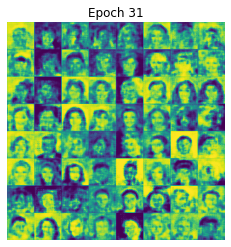


 epoch 32, lg = -0.115835, ld = -0.032363

 epoch 33, lg = -0.035511, ld = -0.035016

 epoch 34, lg = 0.023211, ld = -0.035281

 epoch 35, lg = 0.043482, ld = -0.038282

 epoch 36, lg = 0.080485, ld = -0.037632

 epoch 37, lg = 0.134834, ld = -0.038438

 epoch 38, lg = 0.189554, ld = -0.038620

 epoch 39, lg = 0.197791, ld = -0.037300


KeyboardInterrupt: 

In [22]:
from tqdm import tqdm 



for ep in range(W_EPOCH):
    lgt = 0.0
    ldt = 0.0
    for c1 in dataset_train:
        lg, ld = WTrain[ctr](c1)
        ctr += 1
        lgt += lg.numpy()
        ldt += ld.numpy()
        if ctr == WCritic : ctr = 0
    wlg[ep] = lgt * rsTrain
    wld[ep] = ldt * rsTrain
    print('\n epoch {}, lg = {:.6f}, ld = {:.6f}'.format(ep, wlg[ep] , wld[ep]))
    
    s = tf.random.normal([SAMPLE_NUM, Z_DIM])
    out = WG(s, training = False)
    img = utPuzzle(
        (out * 255.0).numpy().astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        "./results/w_%04d.png" % ep
    )
    wsp[ep] = img
    if (ep+1) % 32 == 0:
        
        plt.imshow(img[..., 0])
        plt.axis("off")
        plt.title("Epoch %d" % ep)
        plt.show()

In [24]:
utMakeGif(np.array(wsp[:39]), "imgs/improved_wgan.gif", duration = 2)

t:   5%|▌         | 2/39 [00:00<00:02, 18.18it/s, now=None]

MoviePy - Building file imgs/improved_wgan.gif with imageio.



t: 100%|██████████| 39/39 [00:04<00:00,  7.15it/s, now=None]
                                                            

D has very large loss in the first 3 epochs so I just ignored them in the plot

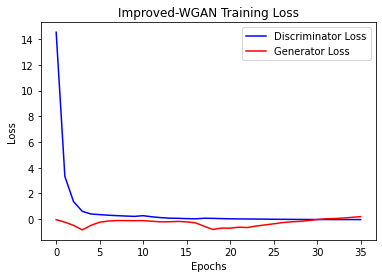

In [28]:
plt.plot(range(36), wld[3:39], color = "blue", label = "Discriminator Loss")
plt.plot(range(36), wlg[3:39], color = "red", label = "Generator Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Improved-WGAN Training Loss")
plt.show()